In [15]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy import optimize
import os
import glob

# Superconducting Data Fitting

## Temperature dependence of R near $T_c$

### Aslamazov-Larkin equation

$$\sigma _ { 3 \mathrm { D }}= \frac { e ^ { 2 } } { 32 \hbar \xi ( 0 ) } \epsilon ^ { - 1 / 2 }$$

$$\sigma _ { 2 \mathrm {D}}= \frac { e ^ { 2 } } { 16 \hbar d } \epsilon ^ { - 1 }$$

where
$$\epsilon \equiv \ln \left( \frac { T } { T _ { \mathrm { co } } } \right) \approx \frac { T - T _ { \mathrm { c } 0 } } { T _ { \mathrm { c0 } } }$$

#### Simple Fitting

$$\left( \frac { 1 } { R _ { \square } } - \frac { 1 } { R _ { \mathrm { N } } } \right) ^ { - 1 } = R _ { 0 } \left( \frac { T - T _ { \mathrm { c } 0 } } { T _ { \mathrm { c0 } } } \right)$$

where $R_0$ and $T_{c0}$ are fitting parameters. $R_0=e^2/16h$ in the original AL equation.

In [5]:
# Define a few parameters
Rac=10**6    # ballast resistor 
Vac=1        # AC voltage
Gain=1       # gain from preamplifier
Iac=Vac/Rac  # AC current
Iac

1e-06

In [6]:
Data=pd.DataFrame()

In [7]:
filename='NbSe2-SV07-TSweep-(S2-S9)-(S4\'-S5\')-(S5-S6)-BSeq-Zaxis-0.dat'

#Note here: The sequence should be (S5-S6)-(S4\'-S5\')-(S2-S9)

In [8]:
df=pd.read_csv(str(filename),skiprows=6)
df.head()

,B (T),T(mK),X (V),Y (V),R (V),Phase (Deg),X (V).1,Y (V).1,R (V).1,Phase (Deg).1,X (V).2,Y (V).2,R (V).2,Phase (Deg).2
0,7.0,7.499,0.000009,-3.119950e-08,0.000009,-0.198,0.00001,-3.539050e-08,0.00001,-0.192,0.000052,-0.000004,0.000052,-4.572
1,7.0,7.497,0.000009,-3.166520e-08,0.000009,-0.198,0.00001,-2.887110e-08,0.00001,-0.156,0.000052,-0.000004,0.000052,-4.800
2,7.0,7.493,0.000009,-2.700850e-08,0.000009,-0.174,0.00001,-2.887110e-08,0.00001,-0.156,0.000052,-0.000004,0.000052,-4.374
3,7.0,7.471,0.000009,-2.374880e-08,0.000009,-0.150,0.00001,-3.073390e-08,0.00001,-0.168,0.000052,-0.000004,0.000052,-4.752
4,7.0,7.457,0.000009,-2.468020e-08,0.000009,-0.156,0.00001,-3.166520e-08,0.00001,-0.174,0.000052,-0.000004,0.000052,-4.620


In [19]:
#Rewrite the datastructure: Now data is saved inside a multiindex dataarray
#      two indexes: B and T

width = 0
length = 0

#Rs = R * W/L   
    
def modifydata (dd):
    cc=pd.DataFrame()
    cc2=pd.DataFrame()
    cc=pd.concat( [dd.iloc[:,1],                 # temperature
                   dd.iloc[:,2]/(Iac*Gain)*4.0,      # calculate resistance for D1     Add ratio to convert to sheet resistance.
                   dd.iloc[:,6]/(Iac*Gain),      # calculate resistance for D2   ## Further values can be added below here
                   dd.iloc[:,10]/(Iac*Gain)
                  ],    
                 axis='columns', keys=['T', 'R1' , 'R2', 'R3'])
    #cc2=cc
    #Remove error data: drop certain lines
    cc2=cc.drop(cc.index[55:350])
    cc2=cc2.reset_index(drop=True)
    ##Remove duplicate data: function with conditions
    ##Algorithm: sort first before drop, keep the first term
    cc2.sort_values(by=['T'], ascending=False)
    cc2=cc2.drop_duplicates('T', keep='first')
    cc2=cc2.set_index('T')
    return cc2

currentdic=[]
for file in os.listdir("."):
    if file.endswith(".dat"):
        currentdic.append(file)


frame = []
BStrength = []
for i in currentdic:
    dataname=i
    df=pd.read_csv(dataname,skiprows=6)
    cc = modifydata(df)
    frame.append(cc)
    BStrength.append( np.around( np.mean( df.iloc[:,0] ), decimals=1 ) )
    
exdata = pd.concat(frame, keys=BStrength, names=['B', 'T'])

exdata


R1         R2         R3
B   T                                     
7.0 7.499  36.170920  10.446700  52.068600
    7.497  36.156040  10.449500  51.707300
    7.493  36.154160  10.453200  51.845100
    7.471  36.143000  10.451400  52.068600
    7.457  36.141120  10.449500  51.539600
    7.441  36.135560  10.451400  51.897300
    7.424  36.131840  10.452300  51.889800
    7.406  36.137400  10.454200  51.521000
    7.388  36.131840  10.452300  51.901000
    7.369  36.118800  10.446700  51.643900
    7.352  36.098280  10.443900  51.524700
    7.333  36.098280  10.443000  51.882400
    7.315  36.098280  10.440200  51.521000
    7.298  36.096440  10.439300  51.554500
    7.279  36.102040  10.441100  51.837600
    7.262  36.126240  10.443000  51.357100
    7.244  36.143000  10.444800  51.744500
    7.227  36.139280  10.442000  51.711000
    7.209  36.116920  10.439300  51.498600
    7.190  36.094560  10.436500  51.889800
    7.174  36.087120  10.434600  51.707300
    7.157  36.085240  10.432700  51.595500
    7.142  36.079680  10.430900  52.064900
    7.125  36.075960  10.431800  51.532200
    7.109  36.077800  10.434600  51.714700
    7.093  36.077800  10.435500  51.889800
    7.078  36.068480  10.435500  51.521000
    7.063  36.057320  10.435500  51.882400
    7.047  36.059200  10.435500  51.711000
    7.034  36.059200  10.434600  51.532200
...              ...        ...        ...
2.5 4.565   0.126661   0.034459   0.178815
    4.561   0.130386   0.029802   0.000000
    4.556   0.113622   0.027009   0.000000
    4.551   0.147150   0.027940   0.178815
    4.547   0.137837   0.027940   0.000000
    4.542   0.121073   0.033528   0.178815
    4.538   0.102446   0.032597   0.000000
    4.533   0.100583   0.039116   0.000000
    4.528   0.130386   0.032597   0.178815
    4.524   0.111759   0.026077   0.178815
    4.519   0.119210   0.029802   0.178815
    4.514   0.152738   0.030734   0.178815
    4.510   0.109896   0.028871   0.000000
    4.505   0.126661   0.023283   0.000000
    4.501   0.083820   0.022352   0.156463
    4.496   0.121073   0.037253   0.000000
    4.492   0.139699   0.025146   0.178815
    4.487   0.113622   0.023283   0.178815
    4.482   0.102446   0.029802   0.178815
    4.478   0.126661   0.039116   0.000000
    4.473   0.154600   0.032597   0.178815
    4.469   0.126661   0.027009   0.000000
    4.464   0.130386   0.013970   0.000000
    4.460   0.175090   0.029802   0.000000
    4.455   0.130386   0.029802   0.000000
    4.451   0.104308   0.029802   0.000000
    4.446   0.072644   0.034459   0.093133
    4.442   0.126661   0.040047   0.000000
    4.437   0.124798   0.035391   0.000000
    4.433   0.137837   0.027009   0.178815

[12377 rows x 3 columns]

<IPython.core.display.Javascript object>


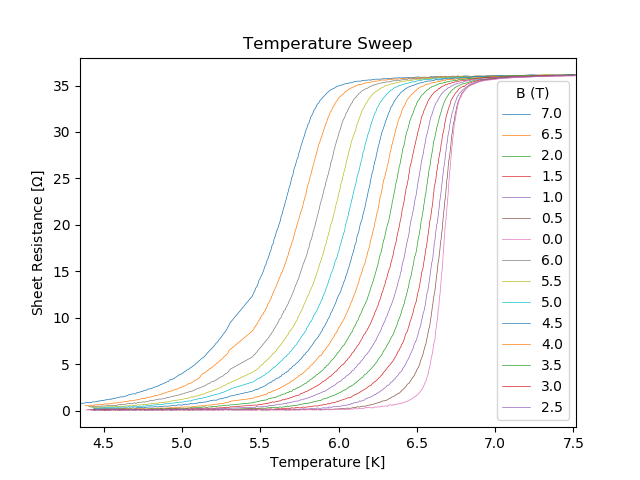

Text(0.5, 1.0, 'Temperature Sweep')

In [20]:

fig, a = plt.subplots()

R1 = exdata['R1']
R3 = exdata['R3']

for i in range(0,15,1):
    R1[BStrength[i]].plot( label=BStrength[i], linestyle='solid',linewidth=0.5 )

#default plotting method could not give a precise graph
    
plt.legend(title='B (T)', loc='lower right')
plt.ylabel('Sheet Resistance [$\Omega$]')
plt.xlabel('Temperature [K]')
plt.title('Temperature Sweep')

<IPython.core.display.Javascript object>


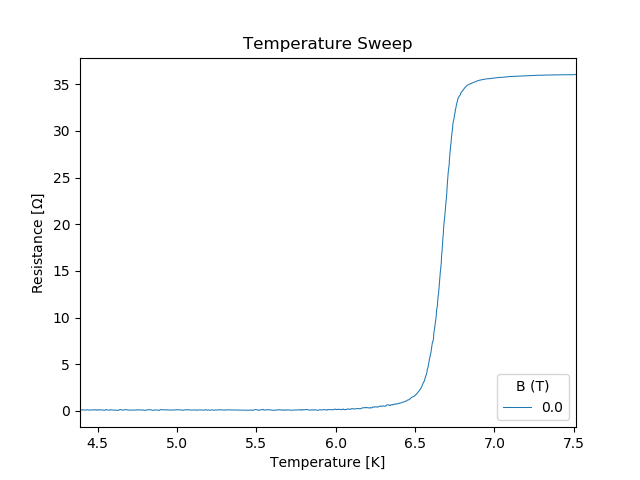

Text(0.5,1,'Temperature Sweep')

In [8]:
#Plot specific data graph
#Choose wanted nth group of data or certain B value

n=14
#Bn = 0.0   #Then replace BStrength[n] to Bn

fig, ax = plt.subplots()
R1[BStrength[n]].plot( label=BStrength[n], linestyle='solid',linewidth=0.75 )
plt.legend(title='B (T)', loc='lower right')
plt.ylabel('Resistance [$\Omega$]')
plt.xlabel('Temperature [K]')
plt.title('Temperature Sweep')

In [86]:
# set fitting goal here:
n = 14
print('Below results are fitting for B field strength equals ' + str(BStrength[n]) + ' T \n')

Rn=R1[BStrength[n]].tolist()
T=R1[BStrength[n]].index.values.tolist() 

# find 0.5Rn
for mid in range(1, len(Rn)):
    if Rn[mid] < 0.5 * Rn[0]:
        break

print('Total data size: ' + str(len(T)) + '\n')
print('Mid value position: ' + str(mid) + '\n')
print('Tc0 initial value: ' + str(T[mid]) + '\n')
print('Ratio over Rn: ' + str(Rn[mid]/Rn[0]) + '\n')

#Define a few parameters
Tc0i=T[mid] 
e=1.6*10**(-19)
h=6.626*10**(-34)
hbar = h/(2*np.pi)
G0i=e**2/(16*hbar)
print('Value of G0: ' + str(G0i) + '\n')
Rn0=Rn[0]*1.01     # regard Rn as constant  
params=G0i, Tc0i# Use R0i and T(R=0.5Rn) as initial parameters for fitting

def AL(t, G0, Tc0):
    return 1/( G0*Tc0 / (t-Tc0)  + 1/Rn0 )

for j in range (5):
    params, params_covariance = optimize.curve_fit(AL, T[:mid], Rn[:mid], params)

    
print( 'Fitted parameters: ')
print(params , params_covariance)

np.linalg.norm(Rn[:mid]-AL(T[:mid], *params))


ss_res_sum = 0
ss_tot_sum = 0
for i in range(0, len(T[:mid-30]), 1):
    ss_res = np.sum((Rn[i] -AL(T[i], *params) ) ** 2)
    ss_res_sum += ss_res
    ss_tot = np.sum((Rn[i] - np.mean(Rn[:mid-30])) ** 2)
    ss_tot_sum += ss_tot

    

R2 = 1 - (ss_res_sum / ss_tot_sum)
print(R2)



Below results are fitting for B field strength equals 0.0 T 

Total data size: 826

Mid value position: 107

Tc0 initial value: 6.672999999999999

Ratio over Rn: 0.4962546567175439

Value of G0: 1.5172195127508814e-05

Fitted parameters: 
[6.28586264e-05 6.66324720e+00] [[ 7.56983616e-12 -2.51686596e-09]
 [-2.51686596e-09  1.26986752e-06]]
0.6074520091323281


<IPython.core.display.Javascript object>


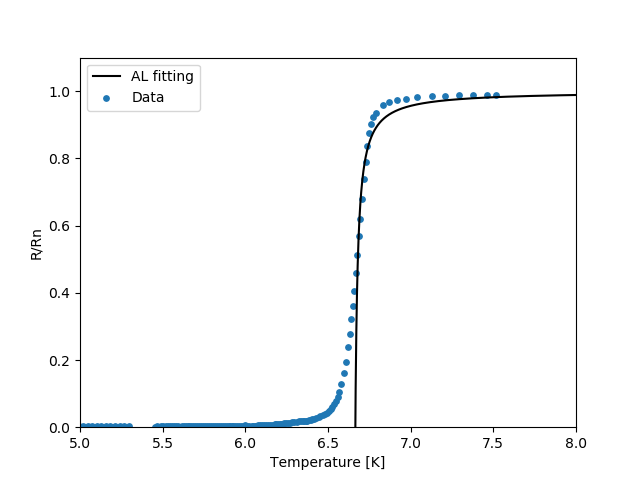

In [72]:
fig, ax1 = plt.subplots()
# plot data
ax1.scatter( T[::5] , list(map(lambda x: x/Rn0, Rn[::5])) , s=15, label='Data')
# plot fitted curve
xfine=np.linspace(params[1],8.0,1000)
ax1.plot(xfine, AL(xfine, params[0], params[1]*1.0003)/Rn0,label='AL fitting', color='k')
# figure makeup
plt.legend()
plt.xlim(5,8)
plt.ylim(0,1.1)
plt.ylabel('R/Rn')
plt.xlabel('Temperature [K]')
plt.show()
#plt.title('Temperature Sweep')

# Fit by AL + MT term
## Advanced fitting

$$R ( T ) = \left( \frac { 1 } { R _ { \mathrm { N } } ( T ) } + \Delta G _ { \mathrm { SF } } \right) ^ { - 1 }$$

where
$$\frac { 1 } { R _ { \mathrm { N } } ( T ) } = \frac { 1 } { a + b T ^ { 2 } } + \ln \left( \frac { T } { T _ { 0 } } \right)$$

is fitted with measurements when $H > H_c$.
The second term  comes from contributions of weak localisation and Coulomb interaction between particles.

$\Delta G _{\text{SF}}$ is the excess conductance due to superconducting fluctuation.

$$\begin{aligned} \Delta G _ { \mathrm { SF } } & = \Delta G _ { \mathrm { AL } } + \Delta G _ { \mathrm { MT } } + \Delta G _ { \mathrm { DOS } } \\ & = \frac { e ^ { 2 } } { 16 \hbar } \left( \frac { T _ { \mathrm { co } } } { T - T _ { \mathrm { c } 0 } } \right) + \frac { e ^ { 2 } } { 8 \hbar } \cdot\frac { T _ { \mathrm { c } 0 } } { T ( 1 - \Delta ) - T _ { \mathrm { c0 } } } \end{aligned}$$
where $\Delta$ is the pair-breaking parameter.

In [87]:
# set fitting goal here:
n = 14
print('Below results are fitting for B field strength equals ' + str(BStrength[n]) + ' T \n')

Rn=R1[BStrength[n]].tolist()
T=R1[BStrength[n]].index.values.tolist()

# find 0.5Rn
for mid in range(1, len(Rn)):
    if Rn[mid] < 0.5 * Rn[0]:
        break
        
print('Total data size: ' + str(len(T)) + '\n')
print('Mid value position: ' + str(mid) + '\n')
print('Tc0 initial value: ' + str(T[mid]) + '\n')
print('Ratio over Rn: ' + str(Rn[mid]/Rn[0]) + '\n')

#Define a few parameters

e=1.6*10**(-19)
h=6.626*10**(-34)
G0i=e**2/(16.0*hbar)

Rn0=Rn[0]*1.01
# regard Rn as constant
# RNT can only be approximated with data in high T region
# magnitude of a is 10^2 and magnitude of b is 10^-3, which make variation of T^2 is negligble.



def RT(t,Tc0,Delta):
    return 1/(  1/Rn0 + G0i*(Tc0/(t-Tc0)) + 2.0*G0i*(Tc0/(t*(1.0-Delta)-Tc0))  )

Tc0i=T[mid]
Deltai =0
params2 = Tc0i, Deltai # Use Tc0i and Deltai as initial parameters for fitting

for j in range (10):
    params2, params2_covariance = optimize.curve_fit(RT, T[:mid], Rn[:mid], params2)
    
print( 'Fitted parameters: ')
print(params2 , params2_covariance)

ss_res_sum = 0
ss_tot_sum = 0
for i in range(0, len(T[:mid-30]), 1):
    ss_res = np.sum((Rn[i] - RT(T[i], *params2) ) ** 2)
    ss_res_sum += ss_res
    ss_tot = np.sum((Rn[i] - np.mean(Rn[:mid-30])) ** 2)
    ss_tot_sum += ss_tot

R2 = 1 - (ss_res_sum / ss_tot_sum)

print(R2)




Below results are fitting for B field strength equals 0.0 T 

Total data size: 826

Mid value position: 107

Tc0 initial value: 6.672999999999999

Ratio over Rn: 0.4962546567175439

Fitted parameters: 
[ 6.66787125e+00 -1.02126112e-06] [[ 0.02080614 -0.00471451]
 [-0.00471451  0.00106829]]
0.9047377161142052


<IPython.core.display.Javascript object>


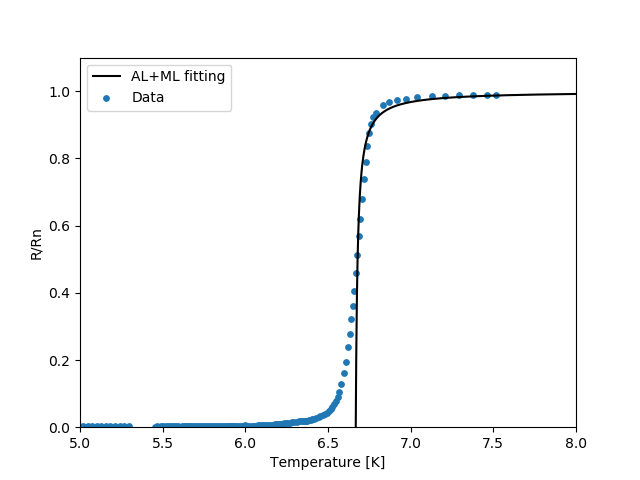

D:\anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [76]:
fig, ax1 = plt.subplots()
# plot data
ax1.scatter( T[::5] , list(map(lambda x: x/Rn0, Rn[::5])) , s=15, label='Data')
# plot fitted curve
xfine=np.linspace(params2[0],8,1000)
ax1.plot(xfine, RT(xfine, params2[0], params2[1])/Rn0,label='AL+ML fitting', color='k')
# figure makeup
plt.legend()
plt.xlim(5,8)
plt.ylim(0,1.1)
plt.ylabel('R/Rn')
plt.xlabel('Temperature [K]')
plt.show()
#plt.title('Temperature Sweep')


### Halperin-Nelsons equation
$$R_{\square} = AR_N \text{exp}\left[ -2b\left(\frac{T_{c0}-T}{T-T_{\text{BKT}}}\right)^{1/2}\right]$$


Corresction: the equation should be

$$R_{\square} = AR_N \text{exp}\left[ \frac{-b}{\left(T-T_{\text{BKT}}\right)^{1/2}}\right]$$

where $A$ and $b$ are constant of order unity and system-dependent parameters.

<IPython.core.display.Javascript object>


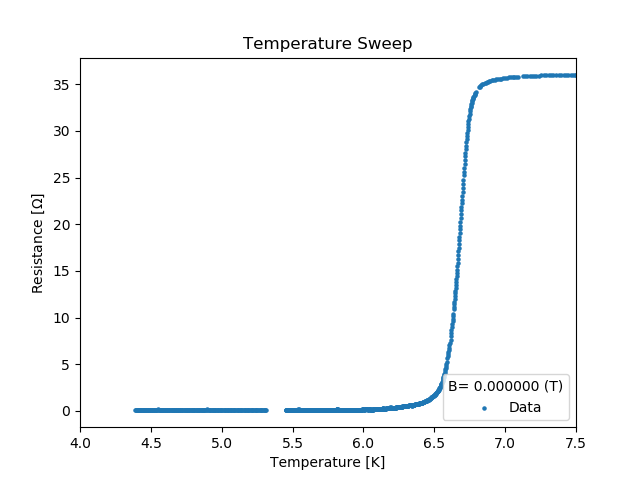

In [13]:
#Plot specific data graph
#Choose wanted nth group of data or certain B value

n=14
#Bn = 0.0   #Then replace BStrength[n] to Bn

fig, ax = plt.subplots()
ax.scatter(R1[BStrength[n]].index.values.tolist(),R1[BStrength[n].tolist()], s=5, label='Data')


    
#ax.set_yscale("log")
#plt.ylim(0.1,100)
plt.xlim(4.0,7.5)

plt.legend(title='B= %f (T)' %BStrength[n], loc='lower right')
plt.ylabel('Resistance [$\Omega$]')
plt.xlabel('Temperature [K]')
plt.title('Temperature Sweep')
plt.show()

In [89]:
# set fitting goal here:
n = 14
print('Below results are fitting for B field strength equals ' + str(BStrength[n]) + ' T \n')

Rn=R1[BStrength[n]].tolist()
T=R1[BStrength[n]].index.values.tolist()

# find 0.5Rn
for mid in range(1, len(Rn)):
    if Rn[mid] < 0.5 * Rn[0]:
        break

#find 0.9Rn
for nt in range(1, len(Rn)):
    if Rn[nt] < 0.9 * Rn[0]:
        break

#find 0.1Rn
for ten in range(1, len(Rn)):
    if Rn[ten] < 0.1 * Rn[0]:
        break
        
print('Total data size: ' + str(len(T)) + '\n')
print('Mid value position: ' + str(mid) + '\n')
print('Tc0 initial value: ' + str(T[mid]) + '\n')
print('Ratio over Rn: ' + str(Rn[mid]/Rn[0]) + '\n')

#Define a few parameters

Ai=10**5
bi=20
Tbkt=6.3

#find Rn larger than Tbkt
for bkt in range(1, len(Rn)):
    if T[bkt] < Tbkt:
        break

print(nt)
print(bkt)
print(ten)
        
params_bkt1=Ai, bi

Rn0=Rn[0]*1.01
# regard Rn as constant

# chop the values in range 10% to 90% by suggestions
#T_select = list(filter(lambda x: x >= Tbkti, T[nt:]))
#Rn_select = list(filter(lambda x: T[nt:][Rn[nt:].index(x)] >= Tbkti, Rn[nt:]))
Rn_select = Rn[nt:ten]
T_select = T[nt:ten]


def HN(T, A, b):
    return A*Rn0*np.exp(-b*np.sqrt(np.abs(1/(T-Tbkt))))

for j in range (1):
    params_bkt1, params_bkt1_covariance = optimize.curve_fit(HN, T_select, Rn_select , params_bkt1, maxfev=5000 )


print(params_bkt1)
print(params_bkt1_covariance)

ss_res_sum = 0
ss_tot_sum = 0
for i in range(0, len(Rn_select), 1):
    ss_res = np.sum((Rn_select[i] - HN(T_select[i], *params_bkt1) ) ** 2)
    ss_res_sum += ss_res
    ss_tot = np.sum((Rn_select[i] - np.mean(Rn_select)) ** 2)
    ss_tot_sum += ss_tot

R2 = 1 - (ss_res_sum / ss_tot_sum)

print(R2)

Below results are fitting for B field strength equals 0.0 T 

Total data size: 826

Mid value position: 107

Tc0 initial value: 6.672999999999999

Ratio over Rn: 0.4962546567175439

68
274
157
[1021.95048357    4.68991135]
[[1.17321626e+04 7.28257938e+00]
 [7.28257938e+00 4.53221054e-03]]
0.988566639646225


<IPython.core.display.Javascript object>


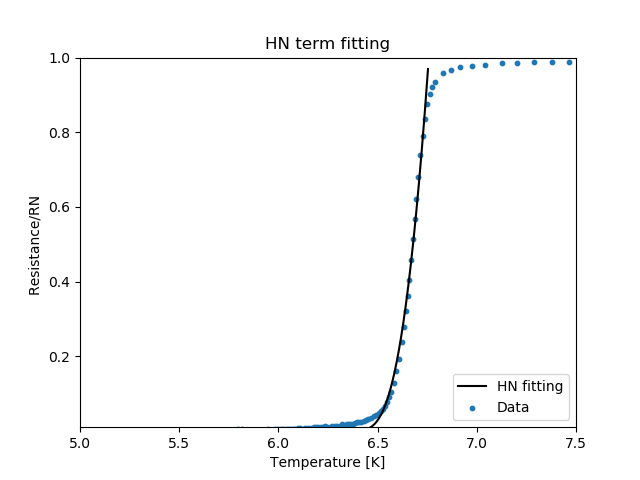

In [90]:
fig, ax = plt.subplots()

# plot data
ax.scatter(T[::5],list(map(lambda x: x/Rn0, Rn[::5])), s=10, label='Data')
# plot fitted curve
xfine=np.linspace(T[bkt],T[nt],1000)
ax.plot(xfine, HN(xfine, params_bkt1[0], params_bkt1[1])/Rn0,label='HN fitting', color='k')


#ax.set_yscale("log")
plt.ylim(0.01,1)
plt.xlim(5.0,7.5)

plt.legend( loc='lower right')
plt.ylabel('Resistance/RN ')
plt.xlabel('Temperature [K]')
plt.title('HN term fitting')
plt.show()